In [95]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [25]:
sql_query = '''
SELECT restaurant_orderitem.id, restaurant_order.datetime, restaurant_product.name, restaurant_orderitem.quantity, restaurant_product.price
FROM restaurant_orderitem
JOIN restaurant_order
ON restaurant_orderitem.order_id = restaurant_order.id
JOIN restaurant_product
ON restaurant_orderitem.product_id = restaurant_product.id
'''

connection = sqlite3.connect("../db.sqlite3")
data = pd.read_sql(sql_query, connection)
data.to_csv("resto_data.csv", index=False)
connection.close()

path_to_data = "resto_data.csv"
df = pd.read_csv(path_to_data)

df["id"].count()

74818

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

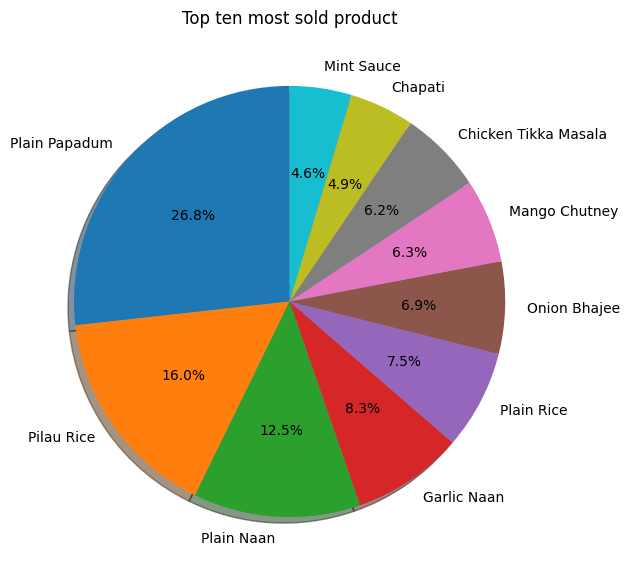

In [103]:
n = 10

quantity_bought = df[["name"]].groupby(["name"]).value_counts("quantity").nlargest(n)
most_sold = df.groupby("name")["quantity"].sum().sort_values(ascending=False).head(10)

labels = most_sold.index.tolist()
plt.figure(figsize=(18,7))
plt.pie(most_sold, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
plt.title("Top ten most sold product")

plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [ ]:
# write your code here

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [ ]:
# write your code here

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [ ]:
# write your code here